<a href="https://colab.research.google.com/github/lsmohan/NARGP/blob/master/pymc3Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic

import matplotlib.pyplot as plt
!pip install arviz
import arviz as az

In [0]:
az.style.use('arviz-darkgrid')
np.random.seed(42)

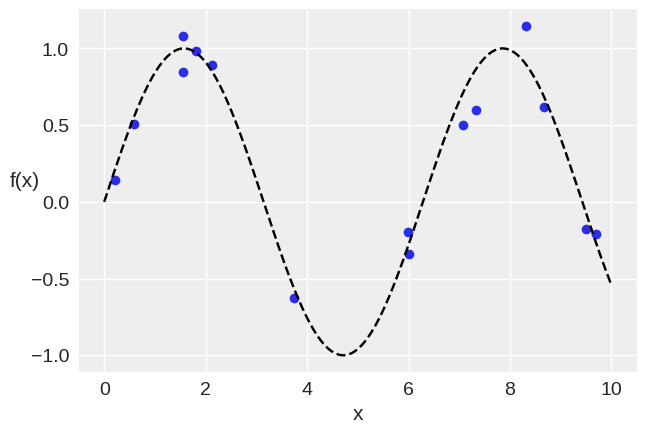

In [3]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)
plt.savefig('B11197_07_04.png')

In [4]:
# A one dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)
    trace_reg = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, ℓ]
100%|██████████| 2500/2500 [00:11<00:00, 213.93it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a10345160>,
      dtype=object)

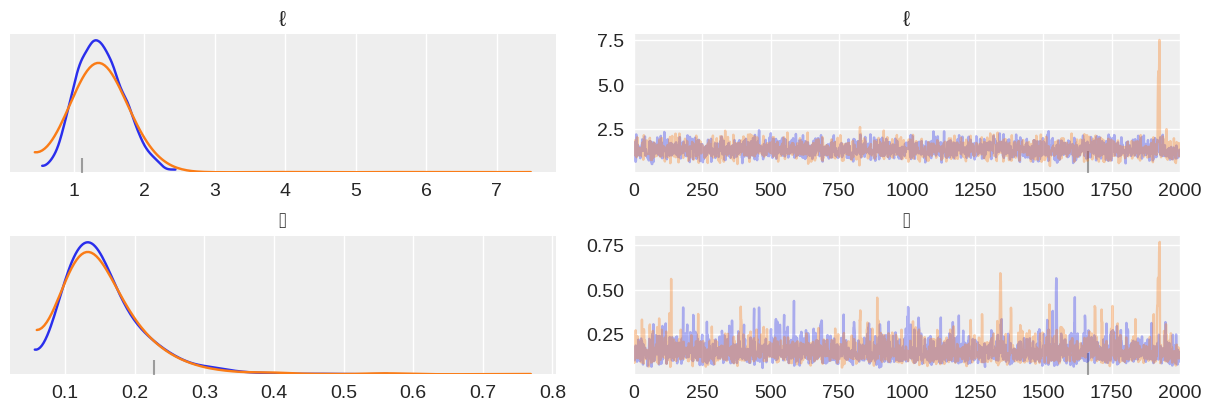

In [5]:
az.plot_trace(trace_reg)

In [0]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    #del marginal_gp_model.named_vars['f_pred']
    #marginal_gp_model.vars.remove(f_pred)
    f_pred = gp.conditional('f_pred', X_new)

In [7]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(trace_reg, vars=[f_pred], samples=82)

100%|██████████| 82/82 [00:02<00:00, 35.84it/s]


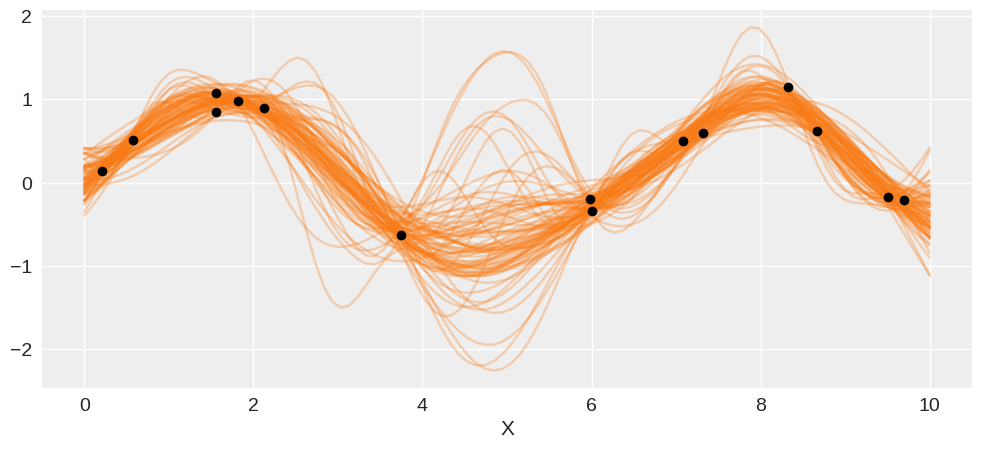

In [8]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.savefig('B11197_07_06.png')

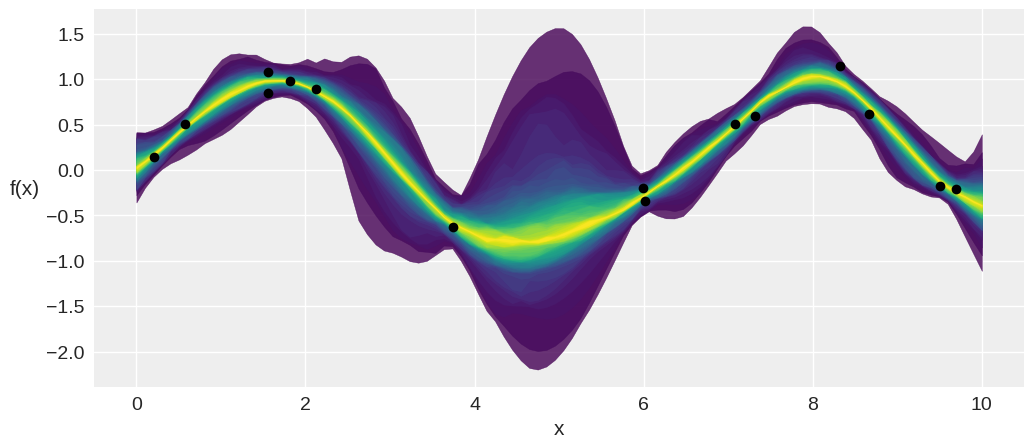

In [9]:
_, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new, palette='viridis', plot_samples=False);

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)
plt.savefig('B11197_07_07.png')

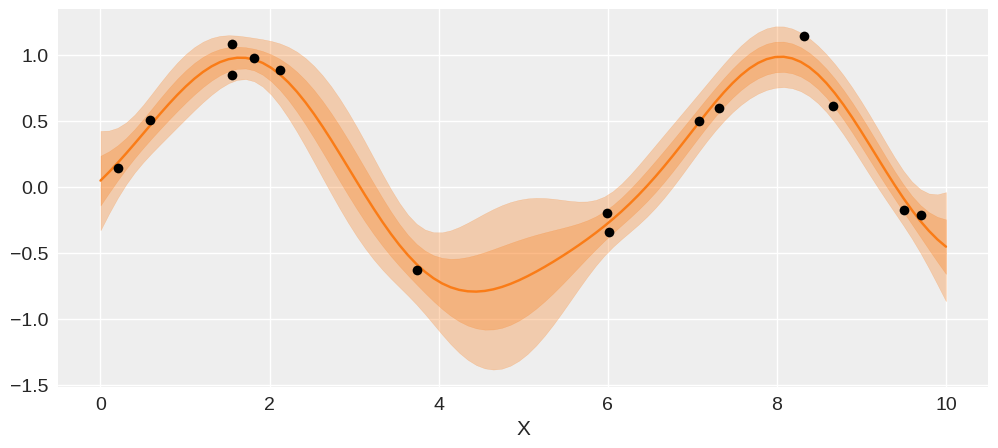

In [10]:
# plot the results
_, ax = plt.subplots(figsize=(12,5))

# predict
point = {'ℓ': trace_reg['ℓ'].mean(), 'ϵ': trace_reg['ϵ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.savefig('B11197_07_08.png')